In [1]:
#|default_exp init

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
inplace??

Signature: inplace(f)
Docstring: <no docstring>
Source:   
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/datasets.py
Type:      function


In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [7]:
def get_model():
    return nn.Sequential(
        conv(1,8),
        conv(8,16),
        conv(16,32),
        conv(32,64),
        conv(64,10, act=False),
        nn.Flatten()
    ).to(def_device)

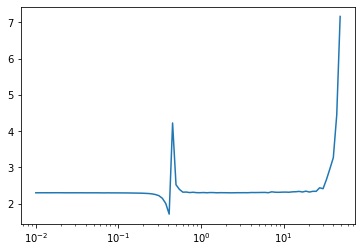

In [8]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.05, cbs=cbs)

accuracy,loss,epoch,state
0.111,2.299,0,train
0.165,2.294,0,eval


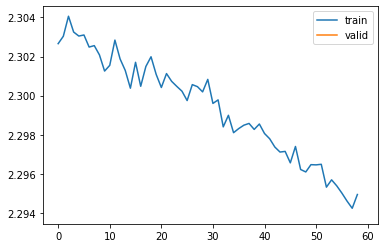

In [10]:
learn.lr=0.01
learn.fit(1)

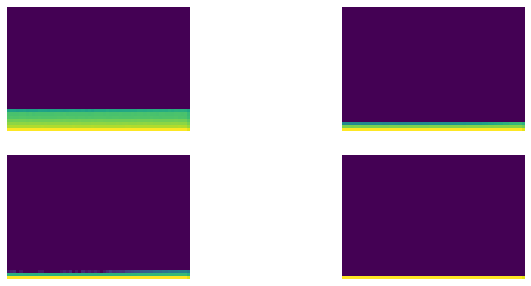

In [11]:
astats.color_dim()

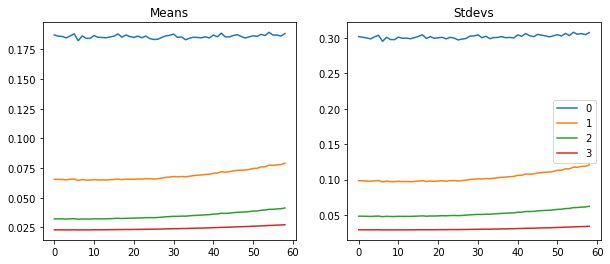

In [12]:
astats.plot_stats()

In [13]:
for x in astats:
    print(x)

In [14]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [15]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
    

In [16]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
x=torch.randn(200,100)
for i in range(50):
    x = x @ torch.randn(100,100)

In [18]:
x.mean(),x[:5,:5]

(tensor(nan),
 tensor([[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]]))

In [19]:
x=torch.rand(200,100)
for i in range(50):
    x=x@ (torch.randn(100,100) * 0.01)
x[:5,:5],x.mean(),x.std()

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]),
 tensor(0.),
 tensor(0.))

In [20]:
x=torch.rand(2000,1000).to('cuda')
den = tensor(1000.).pow(-0.5).to('cuda')
for i in range(100):
    x=x@ (torch.randn(1000,1000,device='cuda') * den)
x[:5,:5],x.mean(),x.std()

(tensor([[-0.03,  0.16, -0.29,  0.36,  0.07],
         [ 0.24,  0.22, -0.02,  0.21,  0.01],
         [-0.28, -0.12, -0.09,  0.18,  0.21],
         [ 0.13,  0.17, -0.32,  0.40, -0.03],
         [-0.12, -0.14, -0.40,  0.62, -0.37]], device='cuda:0'),
 tensor(-0.01, device='cuda:0'),
 tensor(0.44, device='cuda:0'))

In [21]:
x=(1,3,4,5,7,8,11)
x=tensor(x).float()
# tensor.var automatically used unbiased variance estimate which subtracts 1 from N in denominator
# otherwise, variance(x) = E(x^2) - E(x)^2
(x-x.mean()).pow(2).mean(),x.var(unbiased=False),(x**2).mean() - (x.mean()**2)
# see torch.var??

(tensor(9.67), tensor(9.67), tensor(9.67))

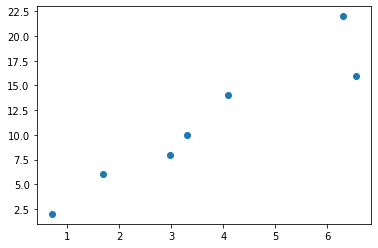

In [22]:
u=2*x
x *= torch.randn_like(x) / 10 + 0.7
plt.scatter(x,u)

In [23]:
prod = (x-x.mean()) * (u-u.mean())
prod,prod.mean()

(tensor([27.05, 10.13,  2.16,  0.40,  1.23, 14.05, 28.71]), tensor(11.96))

In [24]:
ran=torch.randn_like(x)
prod=(x-x.mean()) * (ran - ran.mean())
prod,prod.mean()

(tensor([-1.61,  0.57, -0.43,  0.35,  0.02,  1.87, -1.48]), tensor(-0.10))

covariance: if they both shift away from mean at a given element, do they go in same or opposite directions away? if go the same direction, signs match and product is positive for that element.

for different elements, are the products largely positive or negative? if all negative, they covary quite predictably in a negative way and the mean is negative, and far from zero. if largely positive, the opposite.

if they, say, alternate back and forth with about the same swing one direction then the other, the products cancel out, positive and negative ones all averaging out to zero.

In [25]:
a=tensor([1,2,3,4.])
b=tensor([4,3,2,1])
# torch.covar takes in a tensor, rows=vars, cols=observations, and outputs a covariance matrix, diagonal, of covar
# by default torch.covar does an unbiased estimator, subtracting 1 from N in denominator, as well, so the diagonals
# match unbiased variance estimate


# between each pair of variables. diagonal entries are the individual variances of each var.
print(torch.cov(torch.stack((a,b))),a.var()) # they're equal-opposite directions covarient
c=tensor([2.5] * 4)
print(torch.cov(torch.stack((a,c)))) # c covaries with itself 0 and with a 0.
# a covaries with c 0 because c's variance is 0 which nixes any covariance - elementwise mult by a 0 vector
print((a-a.mean()) * (c-c.mean()), (c-c.mean()))

# if d is very close to a, then a covar d will just be extremely close to var of a
d=a.clone()
d*=1.02
d+= .02
print(a,d)
print(torch.cov(torch.stack((a,d))))
print(((a-a.mean())**2).mean())

tensor([[ 1.67, -1.67],
        [-1.67,  1.67]]) tensor(1.67)
tensor([[1.67, 0.00],
        [0.00, 0.00]])
tensor([-0., -0., 0., 0.]) tensor([0., 0., 0., 0.])
tensor([1., 2., 3., 4.]) tensor([1.04, 2.06, 3.08, 4.10])
tensor([[1.67, 1.70],
        [1.70, 1.73]])
tensor(1.25)


In [26]:
cov=prod.mean()
cov / (x.std() * u.std())

tensor(-0.01)

In [27]:
torch.corrcoef??

Docstring:
corrcoef(input) -> Tensor

Estimates the Pearson product-moment correlation coefficient matrix of the variables given by the :attr:`input` matrix,
where rows are the variables and columns are the observations.

.. note::

    The correlation coefficient matrix R is computed using the covariance matrix C as given by
    :math:`R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }`

.. note::

    Due to floating point rounding, the resulting array may not be Hermitian and its diagonal elements may not be 1.
    The real and imaginary values are clipped to the interval [-1, 1] in an attempt to improve this situation.

Args:
    input (Tensor): A 2D matrix containing multiple variables and observations, or a
        Scalar or 1D vector representing a single variable.

Returns:
    (Tensor) The correlation coefficient matrix of the variables.

.. seealso::

        :func:`torch.cov` covariance matrix.

Example::

    >>> x = torch.tensor([[0, 1, 2], [2, 1, 0]])
    >>> torch.cor

In [28]:
inp=torch.stack((x,u))
corr = torch.corrcoef(inp)

In [29]:
ls=torch.zeros((2,2))
c=torch.cov(inp)
for i in 0,1:
    for j in 0,1:
        ls[i,j] = c[i,j]/ (c[i,i] * c[j,j]).sqrt()
ls, corr # correlation matrix also operates in the unbiasing way and with a differently worded
# but equivalent formula as Jeremy mentions, since sqrt(a^2b^2)=ab because (k^a)^b = k^(ab)

(tensor([[1.00, 0.95],
         [0.95, 1.00]]),
 tensor([[1.00, 0.95],
         [0.95, 1.00]]))

In [30]:
s=0.
sq=0.
k=1000
for _ in range(k):
    
    a=torch.randn(10000, device='cuda')
    b=torch.randn(10000, device='cuda')
    c=a.dot(b)
    s+=c
    sq+=c.pow(2)
c=s/float(k)
a.mean(),b.mean(),c,sq/float(k)

(tensor(-0.00, device='cuda:0'),
 tensor(-0.00, device='cuda:0'),
 tensor(-0.31, device='cuda:0'),
 tensor(10878.85, device='cuda:0'))

In [31]:
model = get_model()
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(m.weight)

model.apply(init_weights);

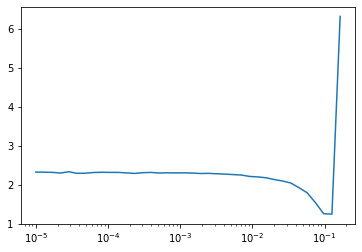

In [32]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [33]:
set_seed(42)
learn=MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,state
0.587,1.231,0,train
0.781,0.594,0,eval
0.819,0.487,1,train
0.836,0.449,1,eval
0.845,0.419,2,train
0.851,0.409,2,eval


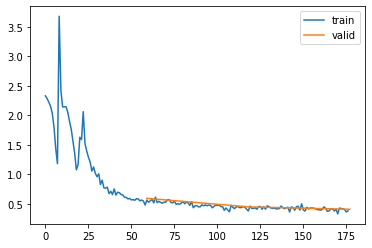

In [34]:
learn.fit(3)

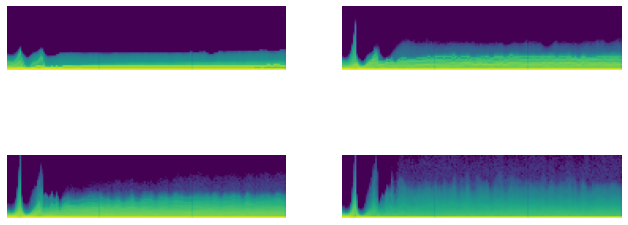

In [35]:
astats.color_dim()

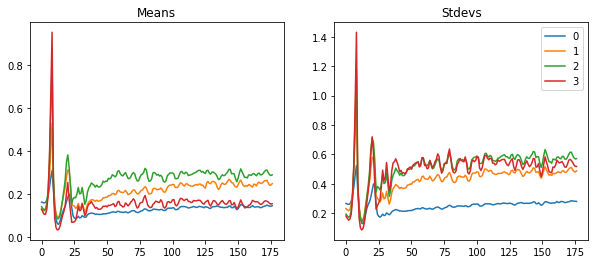

In [36]:
astats.plot_stats()

In [37]:
xb.mean(),xb.std(),xb.shape,yb

(tensor(0.29),
 tensor(0.35),
 torch.Size([1024, 1, 28, 28]),
 tensor([5, 7, 4,  ..., 8, 0, 3]))

In [38]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, transform, on_train=True, on_val=True):
        fc.store_attr()
    
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.transform(learn.batch)

In [39]:
xmean=xb.mean()
xstd=xb.std()
def _norm(b):
    return (b[0] - xmean) / xstd, b[1]
normcb = BatchTransformCB(_norm)

In [40]:
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs + [normcb])

accuracy,loss,epoch,state
0.480,1.610,0,train
0.753,0.662,0,eval


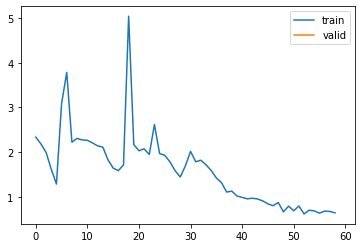

In [41]:
learn.fit(1)

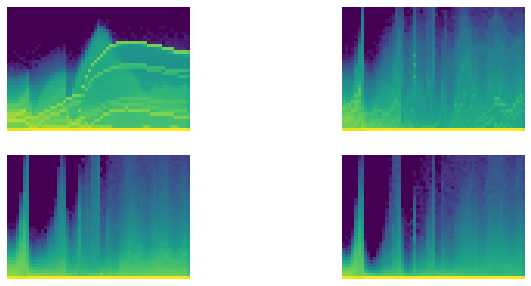

In [42]:
astats.color_dim()

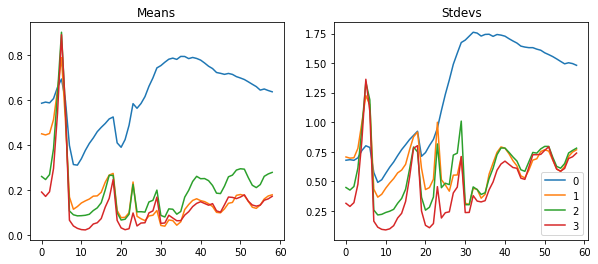

In [43]:
astats.plot_stats()

In [44]:
@inplace
def transformi(b):
    b['image']= [(TF.to_tensor(o) - xmean) / xstd for o in b['image']]
    
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb=next(iter(dls.train))

In [45]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        fc.store_attr()
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x -= self.sub
        
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x


In [46]:
t=torch.randn((10))
GeneralRelu()(t)

tensor([1.23, 1.66, 1.99, 0.00, 0.00, 0.40, 0.00, 0.93, 1.29, 0.27])

In [47]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x=torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

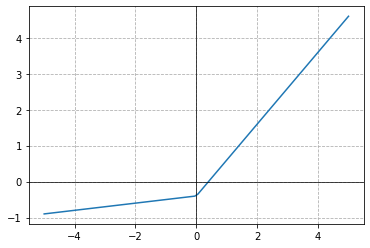

In [48]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [49]:
def conv(in_channels, out_channels, kernel_size=3, stride=2, activation=nn.ReLU):
    result = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size, padding=kernel_size//2)
    if activation is not None:
        # Note: activation is supposed to be a Type which is to be instantiated here into something which will be
        # callable as the activation function. The actual callable activation function is not to be passed in.
        result = nn.Sequential(result, activation())
    
    return result

In [50]:
def get_model(activation=nn.ReLU, channel_layers=None):
    if channel_layers is None:
        channel_layers = [1,8,16,32,64]
    
    layers = [conv(channel_layers[i],
                   channel_layers[i+1],
                   activation=activation
                  ) for i in range(len(channel_layers) - 1)] + [
        conv(channel_layers[-1], 10, activation=None),
        nn.Flatten()
    ]
    
    return nn.Sequential(*layers).to(def_device)

In [51]:
#| export
def init_weights(model, leaky=0.0):
    if isinstance(model, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(model.weight, a=leaky)

In [89]:
acts_genrelu = partial(GeneralRelu, leak=0.1, sub=0.4)

astats=ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
initweights_partial = partial(init_weights, leaky=0.1)

model=get_model(acts_genrelu).apply(initweights_partial)

set_seed(42)
learn = MomentumLearner(model,dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

KeyboardInterrupt: 

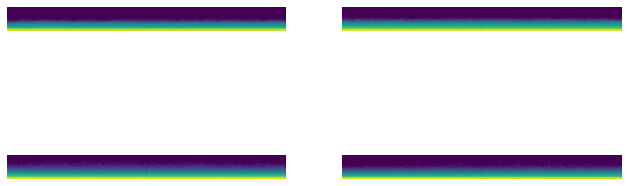

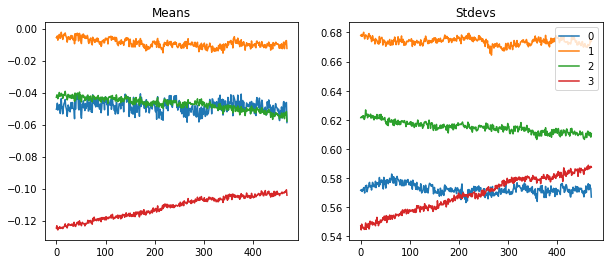

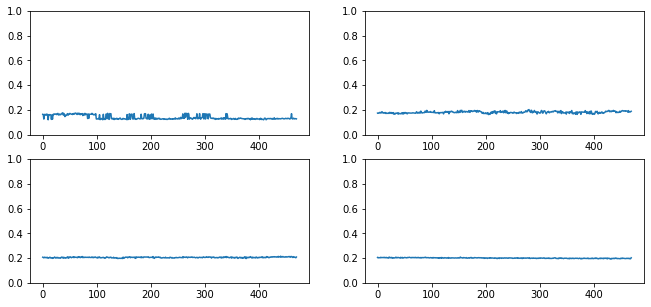

In [71]:
astats.color_dim()
astats.plot_stats()
astats.dead_chart()

## layer-wise sequential unit variance, LSUV

In [72]:
#| export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, act_module, weight_module, xb):
    h = Hook(act_module, _lsuv_stats)
    with torch.no_grad():
        model(xb)
        while (abs(h.std-1) > 1e-3 or abs(h.mean) > 1e-3):
            weight_module.bias -= h.mean
            weight_module.weight.data /= h.std
            model(xb)
    h.remove()

In [73]:
model = get_model(acts_genrelu)
relus=[m for m in model.modules() if isinstance(m, GeneralRelu)]
convs=[m for m in model.modules() if isinstance(m, nn.Conv2d)]

In [74]:
for pair in zip(relus, convs): print(pair)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [75]:
for pair in zip(relus, convs):
    lsuv_init(model, pair[0], pair[1], xb.to(def_device))

accuracy,loss,epoch,state
0.816,0.515,0,train
0.843,0.428,0,eval


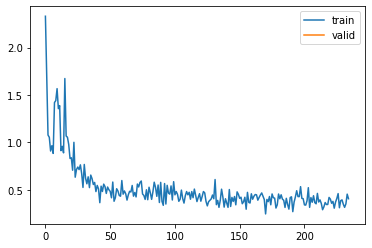

In [76]:
learn=MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

accuracy,loss,epoch,state
0.868,0.361,0,train
0.849,0.418,0,eval


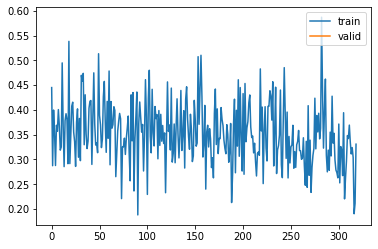

KeyboardInterrupt: 

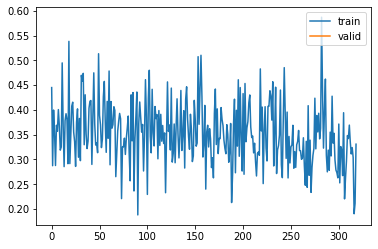

In [77]:
learn.fit(2)

## Batch normalization

In [78]:
act,acts,activation,activations=None,None,None,None




@

In [79]:
class LayerNorm(nn.Module):
    def __init__(self, ignored_num_channels, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        mean = x.mean((1, 2, 3), keepdim=True)
        var = x.var((1, 2, 3), keepdim=True)
        x = (x - mean) / ((var + self.eps).sqrt())
        
        return x * self.mult + self.add

In [80]:
#|export
def conv(in_chans, out_chans, kernel_size=3,stride=2,activation=nn.ReLU,norm=None,bias=None):
    if bias is None:
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    
    layers = [nn.Conv2d(in_chans, out_chans, stride=stride, kernel_size=kernel_size, padding=kernel_size//2, bias=bias)]
    
    if norm:
        layers.append(norm(out_chans))
    
    if activation:
        layers.append(activation())
    
    return nn.Sequential(*layers)

In [81]:
#|export
def get_model(activation=nn.ReLU, channel_layers=None, norm=None):
    if channel_layers is None:
        channel_layers = [1,8,16,32,64]
    
    layers = [conv(channel_layers[i],
                   channel_layers[i+1],
                   activation=activation,
                   norm=norm
                  ) for i in range(len(channel_layers) - 1)] + [
        conv(channel_layers[-1], 10, activation=None, norm=False, bias=True),
        nn.Flatten()
    ]
    
    return nn.Sequential(*layers).to(def_device)


In [82]:
set_seed(42)
model=get_model(acts_genrelu, norm=LayerNorm).apply(initweights_partial)

learn= MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

KeyboardInterrupt: 

## BatchNorm

In [83]:
torch.lerp??

Docstring:
lerp(input, end, weight, *, out=None)

Does a linear interpolation of two tensors :attr:`start` (given by :attr:`input`) and :attr:`end` based
on a scalar or tensor :attr:`weight` and returns the resulting :attr:`out` tensor.

.. math::
    \text{out}_i = \text{start}_i + \text{weight}_i \times (\text{end}_i - \text{start}_i)

The shapes of :attr:`start` and :attr:`end` must be
:ref:`broadcastable <broadcasting-semantics>`. If :attr:`weight` is a tensor, then
the shapes of :attr:`weight`, :attr:`start`, and :attr:`end` must be :ref:`broadcastable <broadcasting-semantics>`.

Args:
    input (Tensor): the tensor with the starting points
    end (Tensor): the tensor with the ending points
    weight (float or tensor): the weight for the interpolation formula

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> start = torch.arange(1., 5.)
    >>> end = torch.empty(4).fill_(10)
    >>> start
    tensor([ 1.,  2.,  3.,  4.])
    >>> end
    tensor([ 1

In [84]:
class BatchNorm(nn.Module):
    def __init__(self, out_chans, momentum=0.1, eps=1e-5):
        super().__init__()
        self.mom = momentum
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(out_chans, 1, 1))
        self.adds = nn.Parameter(torch.zeros(out_chans, 1,1))
        self.register_buffer('vars', torch.ones(1, out_chans, 1,1))
        self.register_buffer('means', torch.zeros(1, out_chans, 1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        
        x = (x-m) / (v + self.eps).sqrt()
        
        return x * self.mults + self.adds

accuracy,loss,epoch,state
0.819,0.497,0,train
0.768,0.673,0,eval
0.873,0.343,1,train
0.828,0.472,1,eval
0.886,0.307,2,train
0.854,0.394,2,eval


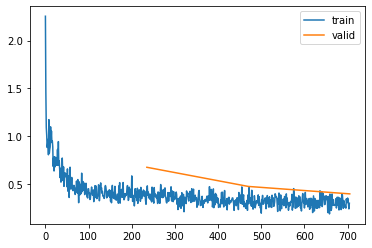

In [85]:
model = get_model(acts_genrelu, norm=BatchNorm).apply(init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,state
0.836,0.450,0,train
0.865,0.366,0,eval
0.885,0.313,1,train
0.878,0.334,1,eval


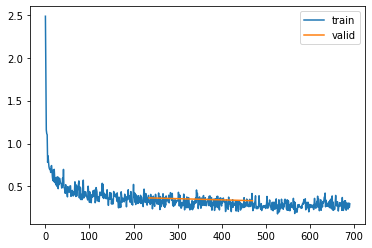

In [ ]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
model=get_model(acts_genrelu, norm=nn.BatchNorm2d).apply(initweights_partial)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

In [88]:
import nbdev; nbdev.nbdev_export()